# Variational Autoencoder (VAE) on MNIST

This tutorial demonstrates how to build and train a **Variational Autoencoder (VAE)** using BrainState. VAEs are powerful generative models that learn to encode data into a latent space and decode it back, enabling both reconstruction and generation of new samples.

## Learning Objectives

By the end of this tutorial, you will:
- Understand the theory behind Variational Autoencoders
- Build encoder and decoder networks in BrainState
- Implement the VAE loss function (reconstruction + KL divergence)
- Train a VAE on MNIST dataset
- Generate new handwritten digits
- Visualize the latent space

## What is a Variational Autoencoder?

A VAE consists of two main components:

1. **Encoder**: Maps input data `x` to latent representation `z`
   - Outputs mean `μ` and standard deviation `σ` of latent distribution
   - Uses **reparameterization trick**: `z = μ + σ * ε`, where `ε ~ N(0,1)`

2. **Decoder**: Reconstructs input from latent code `z`
   - Maps `z` back to data space
   - Outputs reconstruction `x̂`

**Loss Function**:
```
Loss = Reconstruction Loss + β * KL Divergence
```
- **Reconstruction Loss**: How well we reconstruct the input
- **KL Divergence**: Regularizes latent space to be close to N(0,1)

## Setup and Imports

In [28]:
import typing as tp

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax  # For loss functions
import os
os.environ['HF_ENDPOINT'] = 'https://mirrors.tuna.tsinghua.edu.cn/huggingface'
from datasets import load_dataset

import brainstate
import braintools

# Set random seed for reproducibility
np.random.seed(42)
brainstate.random.seed(42)


## Configuration and Dataset

### Hyperparameters

In [29]:
# Model configuration
latent_size = 32          # Dimension of latent space
hidden_size = 256         # Hidden layer size
image_shape = (28, 28)    # MNIST image shape

# Training configuration
batch_size = 64
steps_per_epoch = 200
epochs = 20
learning_rate = 1e-3
kl_weight = 0.1           # β parameter for KL divergence

print(f"Configuration:")
print(f"  Latent dimension: {latent_size}")
print(f"  Hidden size: {hidden_size}")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {epochs}")

Configuration:
  Latent dimension: 32
  Hidden size: 256
  Batch size: 64
  Epochs: 20


### Load and Preprocess MNIST Dataset

In [35]:
# Load MNIST dataset
print("Loading MNIST dataset...")
dataset = load_dataset('mnist')

# Convert to numpy arrays
X_train = np.array(np.stack(dataset['train']['image']), dtype=np.uint8)
X_test = np.array(np.stack(dataset['test']['image']), dtype=np.uint8)

# Binarize data (threshold at 0)
X_train = (X_train > 0).astype(jnp.float32)
X_test = (X_test > 0).astype(jnp.float32)

print(f"\nDataset loaded:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Image shape: {X_train.shape[1:]}")

Loading MNIST dataset...


README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]


Dataset loaded:
  Training samples: 60000
  Test samples: 10000
  Image shape: (28, 28)


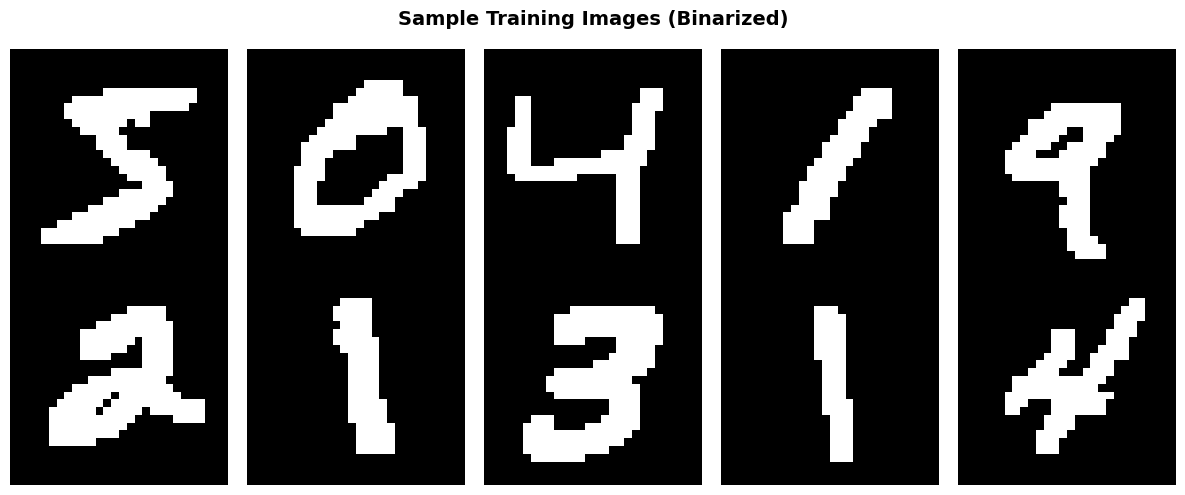

In [36]:
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')
plt.suptitle('Sample Training Images (Binarized)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Building the VAE

### Custom State for Loss Tracking

We'll create a custom state type to track the KL divergence loss within the encoder:

In [37]:
class Loss(brainstate.State):
    """Custom state for tracking loss components."""
    pass

### Encoder Network

The encoder maps images to latent distributions:

In [38]:
class Encoder(brainstate.nn.Module):
    """Encoder network for VAE.
    
    Maps input images to latent distribution parameters (mean and std).
    """
    
    def __init__(self, din: int, dmid: int, dout: int):
        super().__init__()
        
        # Shared hidden layer
        self.linear1 = brainstate.nn.Linear(din, dmid)
        
        # Separate heads for mean and log-variance
        self.linear_mean = brainstate.nn.Linear(dmid, dout)
        self.linear_std = brainstate.nn.Linear(dmid, dout)
    
    def __call__(self, x: jax.Array) -> jax.Array:
        """Encode input to latent representation.
        
        Args:
            x: Input images [batch, height, width]
            
        Returns:
            z: Latent codes [batch, latent_dim]
        """
        # Flatten input
        x = x.reshape((x.shape[0], -1))
        
        # Shared hidden layer with ReLU
        x = self.linear1(x)
        x = jax.nn.relu(x)
        
        # Compute mean and std of latent distribution
        mean = self.linear_mean(x)
        log_std = self.linear_std(x)
        std = jnp.exp(log_std)  # Ensure std > 0
        
        # Compute KL divergence: KL(N(μ,σ²) || N(0,1))
        # KL = 0.5 * (μ² + σ² - log(σ²) - 1)
        kl_loss = 0.5 * jnp.mean(
            -jnp.log(std ** 2) - 1.0 + std ** 2 + mean ** 2, 
            axis=-1
        )
        
        # Store KL loss in state for later retrieval
        self.kl_loss = Loss(jnp.mean(kl_loss))
        
        # Reparameterization trick: z = μ + σ * ε, where ε ~ N(0,1)
        epsilon = brainstate.random.normal(size=mean.shape)
        z = mean + std * epsilon
        
        return z

### Decoder Network

The decoder reconstructs images from latent codes:

In [39]:
class Decoder(brainstate.nn.Module):
    """Decoder network for VAE.
    
    Maps latent codes back to image space.
    """
    
    def __init__(self, din: int, dmid: int, dout: int):
        super().__init__()
        
        self.linear1 = brainstate.nn.Linear(din, dmid)
        self.linear2 = brainstate.nn.Linear(dmid, dout)
    
    def __call__(self, z: jax.Array) -> jax.Array:
        """Decode latent code to reconstruction.
        
        Args:
            z: Latent codes [batch, latent_dim]
            
        Returns:
            logits: Reconstruction logits [batch, height * width]
        """
        # Hidden layer with ReLU
        z = self.linear1(z)
        z = jax.nn.relu(z)
        
        # Output layer (logits for binary cross-entropy)
        logits = self.linear2(z)
        
        return logits

### Complete VAE Model

Combine encoder and decoder:

In [40]:
class VAE(brainstate.nn.Module):
    """Variational Autoencoder.
    
    Combines encoder and decoder for generative modeling.
    """
    
    def __init__(
        self,
        din: int,
        hidden_size: int,
        latent_size: int,
        output_shape: tp.Sequence[int],
    ):
        super().__init__()
        
        self.output_shape = output_shape
        
        # Create encoder and decoder
        self.encoder = Encoder(din, hidden_size, latent_size)
        self.decoder = Decoder(
            latent_size, 
            hidden_size, 
            int(np.prod(output_shape))
        )
    
    def __call__(self, x: jax.Array) -> jax.Array:
        """Forward pass: encode then decode.
        
        Args:
            x: Input images [batch, height, width]
            
        Returns:
            logits: Reconstruction logits [batch, height, width]
        """
        # Encode to latent space
        z = self.encoder(x)
        
        # Decode to reconstruction
        logits = self.decoder(z)
        
        # Reshape to image dimensions
        logits = jnp.reshape(logits, (-1, *self.output_shape))
        
        return logits
    
    def generate(self, z: jax.Array) -> jax.Array:
        """Generate images from latent codes.
        
        Args:
            z: Latent codes [batch, latent_dim]
            
        Returns:
            images: Generated images [batch, height, width]
        """
        logits = self.decoder(z)
        logits = jnp.reshape(logits, (-1, *self.output_shape))
        
        # Apply sigmoid to get probabilities
        return jax.nn.sigmoid(logits)

### Create Model and Optimizer

In [41]:
# Create VAE model
model = VAE(
    din=int(np.prod(image_shape)),
    hidden_size=hidden_size,
    latent_size=latent_size,
    output_shape=image_shape,
)

# Create Adam optimizer
optimizer = braintools.optim.Adam(lr=learning_rate)
optimizer.register_trainable_weights(model.states(brainstate.ParamState))

print("Model created successfully!")
print(f"\nModel architecture:")
print(f"  Input: {np.prod(image_shape)} -> Encoder -> Latent: {latent_size}")
print(f"  Latent: {latent_size} -> Decoder -> Output: {np.prod(image_shape)}")
print(f"\nTotal parameters: {sum(x.size for x in jax.tree.leaves(model.states(brainstate.ParamState).to_dict_values())):,}")

Model created successfully!

Model architecture:
  Input: 784 -> Encoder -> Latent: 32
  Latent: 32 -> Decoder -> Output: 784

Total parameters: 427,344


## Training the VAE

### Define Training Step

The loss function combines reconstruction loss and KL divergence:

In [42]:
@brainstate.transform.jit
def train_step(x: jax.Array):
    """Perform one training step.
    
    Args:
        x: Batch of images [batch, height, width]
        
    Returns:
        loss: Total loss value
    """
    def loss_fn():
        # Forward pass
        logits = model(x)
        
        # Collect KL losses from encoder
        losses = brainstate.graph.treefy_states(model, Loss)
        kl_loss = sum(jax.tree_util.tree_leaves(losses), 0.0)
        
        # Reconstruction loss (binary cross-entropy)
        reconstruction_loss = jnp.mean(
            optax.sigmoid_binary_cross_entropy(logits, x)
        )
        
        # Total loss = reconstruction + β * KL
        total_loss = reconstruction_loss + kl_weight * kl_loss
        
        return total_loss
    
    # Compute gradients and update
    grads, loss = brainstate.transform.grad(
        loss_fn, 
        optimizer.param_states.to_pytree(), 
        return_value=True
    )()
    
    optimizer.update(grads)
    
    return loss

### Helper Functions for Evaluation

In [43]:
@brainstate.transform.jit
def forward(x: jax.Array) -> jax.Array:
    """Forward pass with sigmoid activation."""
    return jax.nn.sigmoid(model(x))


@brainstate.transform.jit
def sample(z: jax.Array) -> jax.Array:
    """Generate samples from latent codes."""
    return model.generate(z)

### Run Training Loop

In [44]:
print("Starting training...\n")

loss_history = []

for epoch in range(epochs):
    epoch_losses = []
    
    for step in range(steps_per_epoch):
        # Sample random batch
        idxs = np.random.randint(0, len(X_train), size=(batch_size,))
        x_batch = X_train[idxs]
        
        # Train step
        loss = train_step(x_batch)
        epoch_losses.append(np.asarray(loss))
    
    # Log progress
    avg_loss = np.mean(epoch_losses)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch + 1:2d}/{epochs}: Loss = {avg_loss:.4f}')

print("\nTraining complete!")

Starting training...

Epoch  1/20: Loss = 0.3331
Epoch  2/20: Loss = 0.2323
Epoch  3/20: Loss = 0.2125
Epoch  4/20: Loss = 0.2023
Epoch  5/20: Loss = 0.1945
Epoch  6/20: Loss = 0.1883
Epoch  7/20: Loss = 0.1838
Epoch  8/20: Loss = 0.1802
Epoch  9/20: Loss = 0.1770
Epoch 10/20: Loss = 0.1750
Epoch 11/20: Loss = 0.1728
Epoch 12/20: Loss = 0.1710
Epoch 13/20: Loss = 0.1699
Epoch 14/20: Loss = 0.1687
Epoch 15/20: Loss = 0.1675
Epoch 16/20: Loss = 0.1672
Epoch 17/20: Loss = 0.1658
Epoch 18/20: Loss = 0.1651
Epoch 19/20: Loss = 0.1647
Epoch 20/20: Loss = 0.1635

Training complete!


### Visualize Training Progress

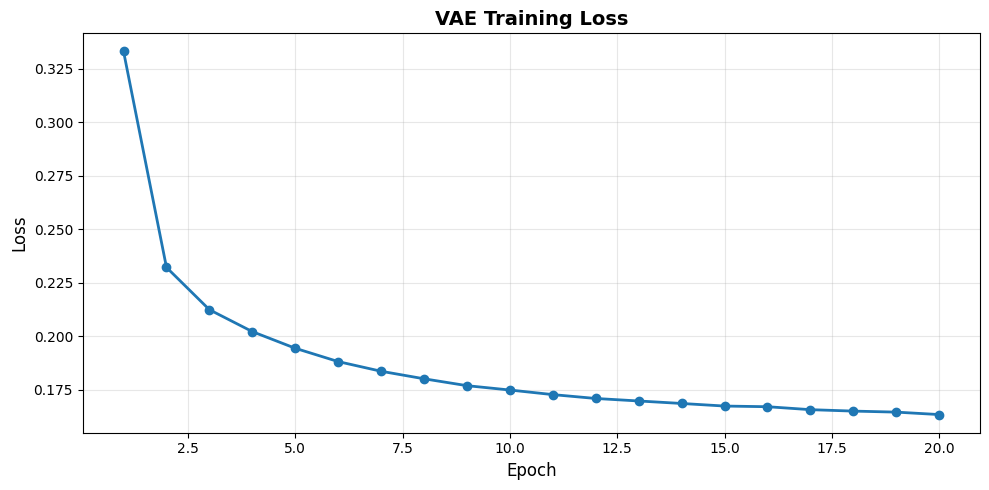

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, marker='o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('VAE Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Evaluation and Visualization

### Reconstruction Quality

Let's see how well the VAE reconstructs test images:

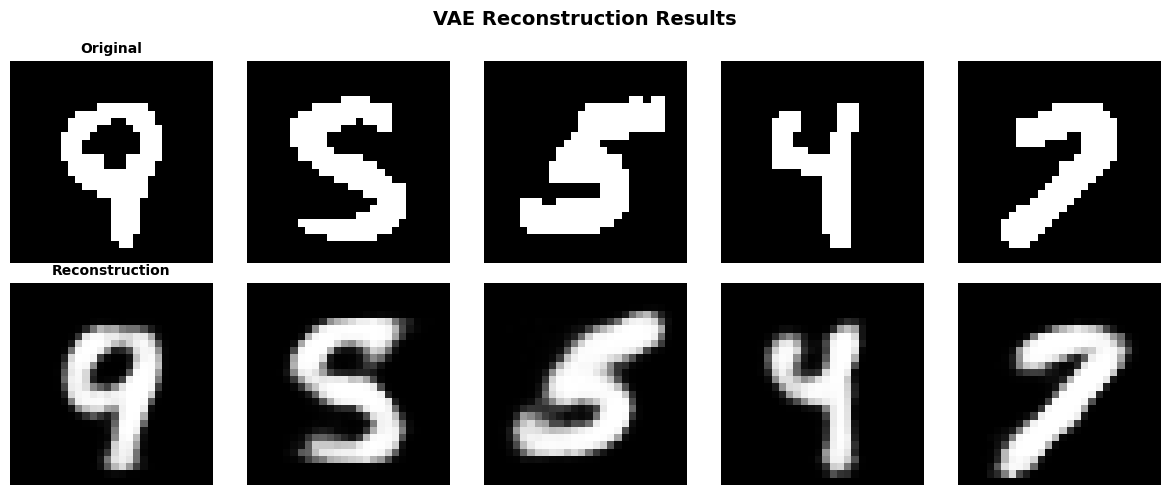

In [47]:
# Get random test samples
num_samples = 5
idxs = np.random.randint(0, len(X_test), size=(num_samples,))
x_sample = X_test[idxs]

# Get reconstructions
y_pred = forward(x_sample)

# Plot original vs reconstruction
fig, axes = plt.subplots(2, num_samples, figsize=(12, 5))

for i in range(num_samples):
    # Original
    axes[0, i].imshow(x_sample[i], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=10, fontweight='bold')
    
    # Reconstruction
    axes[1, i].imshow(y_pred[i], cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstruction', fontsize=10, fontweight='bold')

plt.suptitle('VAE Reconstruction Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Generate New Samples

Sample from the latent space to generate new digits:

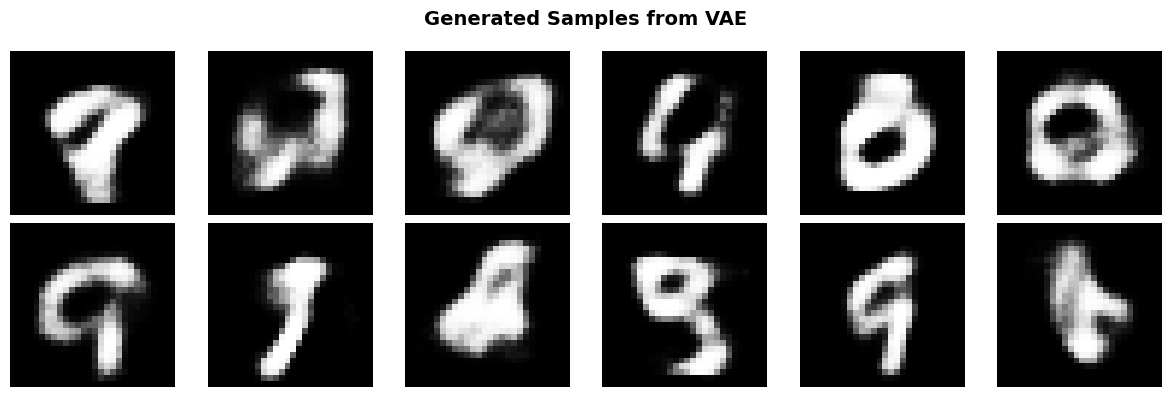

In [48]:
# Sample latent codes from standard normal distribution
z_samples = np.random.normal(scale=1.0, size=(12, latent_size))
samples = sample(z_samples)

# Plot generated samples
fig, axes = plt.subplots(2, 6, figsize=(12, 4))

for i, ax in enumerate(axes.flat):
    if i < len(samples):
        ax.imshow(samples[i], cmap='gray')
    ax.axis('off')

plt.suptitle('Generated Samples from VAE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Latent Space Interpolation

Interpolate between two digits in latent space:

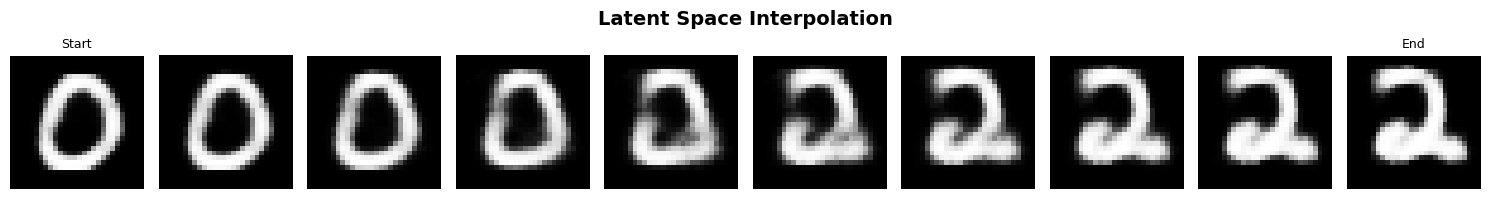

In [49]:
# Get two random samples
idx1, idx2 = np.random.randint(0, len(X_test), size=2)
x1, x2 = X_test[idx1:idx1+1], X_test[idx2:idx2+1]

# Encode to latent space (using the mean, no sampling)
# We'll do this by calling encoder directly
z1 = model.encoder(x1)
z2 = model.encoder(x2)

# Interpolate in latent space
n_steps = 10
alphas = np.linspace(0, 1, n_steps)
z_interp = jnp.array([alpha * z2 + (1 - alpha) * z1 for alpha in alphas]).squeeze()

# Decode interpolated latent codes
samples_interp = sample(z_interp)

# Plot interpolation
fig, axes = plt.subplots(1, n_steps, figsize=(15, 2))

for i, ax in enumerate(axes):
    ax.imshow(samples_interp[i], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('Start', fontsize=9)
    elif i == n_steps - 1:
        ax.set_title('End', fontsize=9)

plt.suptitle('Latent Space Interpolation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Key Concepts Summary

### VAE Architecture

1. **Encoder**:
   - Maps input to latent distribution parameters (μ, σ)
   - Uses reparameterization trick for backpropagation
   - Computes KL divergence as regularization

2. **Decoder**:
   - Maps latent codes to reconstructions
   - Outputs logits (before sigmoid)
   - Enables generation from random samples

3. **Loss Function**:
   - **Reconstruction**: Binary cross-entropy between input and output
   - **KL Divergence**: Regularizes latent space to N(0,1)
   - **β-VAE**: Weight parameter controls trade-off

### BrainState Features Used

1. **Custom State Types**: `Loss` state for tracking KL divergence
2. **State Management**: Automatic handling via lifted transforms
3. **JIT Compilation**: Fast training with `brainstate.transform.jit`
4. **Automatic Differentiation**: Gradients with `brainstate.transform.grad`
5. **Optimizers**: Adam from BrainTools

### Applications of VAEs

- **Image Generation**: Creating new, realistic images
- **Data Compression**: Compact latent representations
- **Anomaly Detection**: Identifying outliers via reconstruction error
- **Semi-Supervised Learning**: Using latent structure
- **Drug Discovery**: Molecular generation and optimization

## Exercises

Try these to deepen your understanding:

1. **Experiment with β**:
   - Try different values of `kl_weight` (0.01, 0.1, 1.0)
   - Observe effect on reconstruction vs. generation quality

2. **Increase Latent Dimension**:
   - Change `latent_size` to 64 or 128
   - Compare reconstruction quality and training time

3. **Convolutional VAE**:
   - Replace linear layers with convolutional layers
   - Use `brainstate.nn.Conv2d` and `brainstate.nn.ConvTranspose2d`

4. **Conditional VAE**:
   - Add digit labels as input to encoder and decoder
   - Generate specific digits on demand

5. **Disentangled Representations**:
   - Implement β-VAE with high β (β > 1)
   - Visualize individual latent dimensions

## Next Steps

Now that you've built a VAE, explore:

1. **Advanced Generative Models**: GANs, diffusion models
2. **Sequence Modeling**: VAEs for time-series data
3. **Brain-Inspired Models**: Spiking VAEs
4. **Model Deployment**: Save and serve trained VAEs

## References

- [Auto-Encoding Variational Bayes (Original Paper)](https://arxiv.org/abs/1312.6114)
- [Tutorial on VAEs](https://arxiv.org/abs/1606.05908)
- [β-VAE Paper](https://openreview.net/forum?id=Sy2fzU9gl)
- [BrainState Documentation](https://brainstate.readthedocs.io/)